<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [3]:
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/main/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [14]:
import spacy.cli
spacy.cli.download("en_core_web_md")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [9]:
import warnings
warnings.filterwarnings("ignore")

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

In [6]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy

import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
pd.set_option('display.max_colwidth', 300)
df = shops
df.sample(5)

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,coffee_shop_name,full_review_text,star_rating
7231,Russell’s Bakery,7/22/2014 Geat pastries. Great Coffee.,5.0 star rating
3624,Cenote,"10/2/2015 1 check-in This place is pretty awesome. Love the outdoor wrap around patio and garden seating, plus the indoor vibe is pleasant and uncramped. The outdoor art is a fun touch -- I regret not taking a selfie with their big green bullfrog statue. The interior space is lovely as well wi...",4.0 star rating
2698,Bennu Coffee,"8/26/2016 Came here for the first time and really enjoyed my visit! The parking lot was completely full, but I managed to find parking along the small road adjacent to the coffee shop (parallel but not metered parking!) Bennu has both outside and inside seating, and when I visited (around 4pm)...",4.0 star rating
3214,Cherrywood Coffeehouse,"6/2/2016 Perhaps I missed this place when I was at UT, but coming back recently, glad to have found this spot. Lots of seating, inside/outside, and tons of different options. It's nice to have a place where you can work at, hang out at, and have that space be pretty versatile.",4.0 star rating
2475,Caffé Medici,9/5/2015 This is definitely my go-to spot whenever I'm downtown and looking for a nice coffee venue to do my work. They commonly host musicians to play while you're enjoying coffee and taking in the downtown views. Their coffee is great although it doesn't stand out as much when compared to ot...,4.0 star rating


In [10]:
# can visit (https://regex101.com/) for a regex python editor (has cheat sheets)

# 1. Remove new line characters
df['clean_text'] = df['full_review_text'].apply(lambda x: re.sub('\s+', ' ', x))

# 2. Remove Emails
df['clean_text'] = df['clean_text'].apply(lambda x: re.sub('From: \S+@\S+', '', x))

# 3. Remove non-alphanumeric characters
df['clean_text'] = df['clean_text'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))

# 4. Remove extra whitespace and lowercase text
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join(x.lower().split()))

In [11]:
df.head()

,coffee_shop_name,full_review_text,star_rating,clean_text
0,The Factory - Cafe With a Soul,"11/25/2016 1 check-in Love love loved the atmosphere! Every corner of the coffee shop had its own style, and there were swings!!! I ordered the matcha latte, and it was muy fantastico! Ordering and getting my drink were pretty streamlined. I ordered on an iPad, which included all beverage selec...",5.0 star rating,check in love love loved the atmosphere every corner of the coffee shop had its own style and there were swings i ordered the matcha latte and it was muy fantastico ordering and getting my drink were pretty streamlined i ordered on an ipad which included all beverage selections that ranged from ...
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambiance in Austin BEAUTIFUL!!!! Love the ambiance! Instagram-worthy!!! Definitely $$$, so be prepared. This is gonna cost you a pretty penny :) Waffle dessert was just decent...nothing to rave about. But, will probably be back just to be somewhere uniq...",4.0 star rating,listed in date night austin ambiance in austin beautiful love the ambiance instagram worthy definitely so be prepared this is gonna cost you a pretty penny waffle dessert was just decent nothing to rave about but will probably be back just to be somewhere unique and nice
2,The Factory - Cafe With a Soul,"11/30/2016 1 check-in Listed in Brunch Spots I loved the eclectic and homey plush decor and who doesn't want to swing and drink their coffee? I would categorize this as a pricier coffee place but, to me it was worth it. After Thanksgiving nobody wants to make brunch so we headed out in search...",4.0 star rating,check in listed in brunch spots i loved the eclectic and homey plush decor and who doesn t want to swing and drink their coffee i would categorize this as a pricier coffee place but to me it was worth it after thanksgiving nobody wants to make brunch so we headed out in search of chicken and waf...
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice seating However... Just about everything is overpriced. $1.50 extra for 3 ounces of Almond Milk in a cortado. No WiFi Music is a bit loud and the mix is odd. Pleasant French oldies followed by loud techno. Several tables were dirty when we got the...,2.0 star rating,very cool decor good drinks nice seating however just about everything is overpriced extra for ounces of almond milk in a cortado no wifi music is a bit loud and the mix is odd pleasant french oldies followed by loud techno several tables were dirty when we got there service is average it feels ...
4,The Factory - Cafe With a Soul,"12/3/2016 1 check-in They are located within the Northcross mall shopping center facing east toward Burnet Rd with plenty of parking. I loved their computerized user friendly ordering system, it made it easy me to pick & choose all the items I wanted to try. I ordered pop tart, chicken & waffle...",4.0 star rating,check in they are located within the northcross mall shopping center facing east toward burnet rd with plenty of parking i loved their computerized user friendly ordering system it made it easy me to pick choose all the items i wanted to try i ordered pop tart chicken waffles strawberry waffles ...


In [16]:
# Leverage tqdm for progress_apply
from tqdm import tqdm
tqdm.pandas()

# from pandarallel import pandarallel
# pandarallel.initialize(progress_bar=True)

# df['lemmas'] = df['full_review_text'].parallel_apply(get_lemmas)

In [15]:
nlp = spacy.load("en_core_web_md", disable=['parser', 'tagger', 'ner'])

In [17]:
# create our tokens in the form of lemmas 
df['lemmas'] = df['clean_text'].progress_apply(lambda x: [token.lemma_ for token in nlp(x) if (token.is_stop != True) and (token.is_punct != True) and (len(token) > 2)])

100%|██████████| 7616/7616 [00:02<00:00, 3770.98it/s]


In [18]:
id2word = corpora.Dictionary(df['lemmas'])
corpus = [id2word.doc2bow(text) for text in df['lemmas']]

In [19]:
# How many words are in our vocab?
len(id2word.keys())

12298

In [20]:
# Let's remove extreme values
id2word.filter_extremes(no_below=3, no_above=0.2)

In [21]:
# How many words are in our vocab?
len(id2word.keys())

5686

In [22]:
# Re-create DTM with new dictionary of vocab
corpus = [id2word.doc2bow(text) for text in df['lemmas']]

In [23]:
id2word[200]

'6'

In [24]:
df.lemmas.iloc[5]

['check',
 'cute',
 'cafe',
 'think',
 'moment',
 'step',
 'wasn',
 'didn',
 'find',
 'cute',
 'factory',
 'decor',
 'cup',
 'cute',
 'perfect',
 'place',
 'catch',
 'friend',
 'coffee',
 'date',
 'order',
 'interaction',
 'worker',
 'pick',
 'order',
 'ipad',
 'order',
 'pick',
 'counter',
 'thing',
 'pretty',
 'novel',
 'honestly',
 'get',
 'viva',
 'matcha',
 'latte',
 'good',
 'perfect',
 'sweetness',
 'perfect',
 'temperature',
 'go',
 'cold',
 'night',
 'cafe',
 'cozy',
 'great',
 'combination',
 'swing',
 'pretty',
 'fun',
 'sit',
 'honestly',
 'price',
 'expect',
 'cafe',
 'like',
 'super',
 'cheap',
 'pricey',
 'wifi',
 'want',
 'study',
 'maybe',
 'isn',
 'right',
 'place',
 'overall',
 'nice',
 'atmosphere',
 'viva',
 'matcha',
 'latte',
 'cortado']

In [25]:
corpus[5] # 6th documents

[(1, 1),
 (8, 1),
 (9, 1),
 (14, 1),
 (15, 2),
 (18, 2),
 (21, 3),
 (23, 2),
 (28, 1),
 (29, 1),
 (36, 1),
 (40, 1),
 (42, 1),
 (43, 1),
 (59, 3),
 (65, 1),
 (68, 1),
 (69, 1),
 (74, 1),
 (75, 1),
 (79, 1),
 (92, 1),
 (98, 2),
 (101, 1),
 (120, 1),
 (121, 1),
 (127, 1),
 (147, 1),
 (174, 1),
 (175, 1),
 (176, 1),
 (177, 1),
 (178, 1),
 (179, 3),
 (180, 1),
 (181, 1),
 (182, 2),
 (183, 1),
 (184, 1),
 (185, 1),
 (186, 1),
 (187, 1),
 (188, 3),
 (189, 1),
 (190, 1),
 (191, 1),
 (192, 1),
 (193, 1),
 (194, 1),
 (195, 1),
 (196, 1),
 (197, 1),
 (198, 2),
 (199, 1)]

In [26]:
[(id2word[word_id], word_count) for word_id, word_count in corpus[5]]

[('atmosphere', 1),
 ('find', 1),
 ('get', 1),
 ('ipad', 1),
 ('latte', 2),
 ('matcha', 2),
 ('order', 3),
 ('pretty', 2),
 ('sweetness', 1),
 ('swing', 1),
 ('date', 1),
 ('go', 1),
 ('nice', 1),
 ('night', 1),
 ('cafe', 3),
 ('cold', 1),
 ('cozy', 1),
 ('decor', 1),
 ('expect', 1),
 ('factory', 1),
 ('friend', 1),
 ('maybe', 1),
 ('pick', 2),
 ('pricey', 1),
 ('want', 1),
 ('wasn', 1),
 ('cortado', 1),
 ('wifi', 1),
 ('catch', 1),
 ('cheap', 1),
 ('combination', 1),
 ('counter', 1),
 ('cup', 1),
 ('cute', 3),
 ('didn', 1),
 ('fun', 1),
 ('honestly', 2),
 ('interaction', 1),
 ('isn', 1),
 ('moment', 1),
 ('novel', 1),
 ('overall', 1),
 ('perfect', 3),
 ('price', 1),
 ('right', 1),
 ('sit', 1),
 ('step', 1),
 ('study', 1),
 ('super', 1),
 ('temperature', 1),
 ('thing', 1),
 ('think', 1),
 ('viva', 2),
 ('worker', 1)]

In [27]:
%%time
lda_multicore = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=20, 
                                                        chunksize=100,
                                                        passes=10,
                                                        per_word_topics=True,
                                                        workers=12)


lda_multicore.save('lda_multicore.model')
# https://radimrehurek.com/gensim/models/ldamulticore.html

CPU times: user 6.92 s, sys: 1.6 s, total: 8.51 s
Wall time: 12 s


In [28]:
from gensim import models
lda_multicore =  models.LdaModel.load('lda_multicore.model')

In [29]:
df.star_rating.value_counts()

 5.0 star rating     3780
 4.0 star rating     2360
 3.0 star rating      738
 2.0 star rating      460
 1.0 star rating      278
Name: star_rating, dtype: int64

In [30]:
# display the print_topics from the model 
pprint(lda_multicore.print_topics())

[(0,
  '0.073*"gelato" + 0.040*"flavor" + 0.022*"chocolate" + 0.019*"favorite" + '
  '0.016*"roll" + 0.014*"delicious" + 0.014*"lavender" + 0.013*"lemonade" + '
  '0.013*"amaze" + 0.012*"italian"'),
 (1,
  '0.017*"don" + 0.012*"know" + 0.008*"wait" + 0.008*"look" + 0.008*"feel" + '
  '0.008*"people" + 0.008*"line" + 0.007*"get" + 0.007*"stop" + 0.007*"make"'),
 (2,
  '0.064*"tea" + 0.049*"scone" + 0.022*"cake" + 0.012*"service" + '
  '0.012*"delicious" + 0.011*"pie" + 0.011*"get" + 0.010*"pastry" + '
  '0.010*"sweet" + 0.010*"quack"'),
 (3,
  '0.015*"food" + 0.009*"table" + 0.009*"server" + 0.008*"dish" + 0.008*"eat" '
  '+ 0.008*"feel" + 0.007*"hummus" + 0.006*"go" + 0.006*"get" + '
  '0.006*"restaurant"'),
 (4,
  '0.028*"free" + 0.022*"beer" + 0.016*"gluten" + 0.015*"seat" + 0.013*"table" '
  '+ 0.013*"selection" + 0.012*"find" + 0.011*"local" + 0.010*"staff" + '
  '0.010*"work"'),
 (5,
  '0.043*"tea" + 0.036*"sandwich" + 0.023*"food" + 0.018*"room" + '
  '0.015*"vegan" + 0.015*"stee

In [38]:
df.clean_text.iloc[1]

'listed in date night austin ambiance in austin beautiful love the ambiance instagram worthy definitely so be prepared this is gonna cost you a pretty penny waffle dessert was just decent nothing to rave about but will probably be back just to be somewhere unique and nice'

In [31]:
df.lemmas.iloc[1]

['list',
 'date',
 'night',
 'austin',
 'ambiance',
 'austin',
 'beautiful',
 'love',
 'ambiance',
 'instagram',
 'worthy',
 'definitely',
 'prepare',
 'go',
 'cost',
 'pretty',
 'penny',
 'waffle',
 'dessert',
 'decent',
 'rave',
 'probably',
 'unique',
 'nice']

In [32]:
doc_lda = lda_multicore[corpus]
doc_lda[1][0]

[(13, 0.057525486), (17, 0.90156)]

In [33]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_multicore, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
16     0.126131  0.097597       1        1  10.197273
8      0.045683 -0.037301       2        1   8.171969
11    -0.019593 -0.114021       3        1   7.909740
15    -0.029603  0.049334       4        1   7.579313
6      0.147012 -0.039589       5        1   7.573325
17    -0.049118 -0.030942       6        1   5.884646
1      0.075798 -0.118449       7        1   4.926380
3      0.039666  0.017950       8        1   4.803354
12     0.037671 -0.069832       9        1   4.479363
18    -0.156811 -0.035358      10        1   4.475847
7      0.052462 -0.000367      11        1   4.332514
5     -0.023709  0.115675      12        1   4.229277
4      0.087909  0.104852      13        1   4.197221
19     0.097758  0.099805      14        1   4.019282
9      0.044464 -0.040988      15        1   3.543643
10     0.045431 -0.018329      16        1   3.334703
13    -0.144892  0.215018      17        1   3.123466
0     -0.186045 -0.094154      18        1   3.017886
2     -0.159820  0.036417      19        1   2.543656
14    -0.030394 -0.137318      20        1   1.657142, topic_info=            Term         Freq        Total Category  logprob  loglift
259          tea  2422.000000  2422.000000  Default  30.0000  30.0000
1144       cream  1048.000000  1048.000000  Default  29.0000  29.0000
1914      gelato   733.000000   733.000000  Default  28.0000  28.0000
2061    sandwich   848.000000   848.000000  Default  27.0000  27.0000
77        flavor  1282.000000  1282.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
143      service    31.994284  1657.131738  Topic20  -5.0182   0.1528
806         lack    25.963909   141.558861  Topic20  -5.2270   2.4041
385       pastry    27.291574   580.934556  Topic20  -5.1771   1.0420
1     atmosphere    27.291534   947.034141  Topic20  -5.1772   0.5533
527      awesome    26.867565   720.681696  Topic20  -5.1928   0.8108

[1501 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
4228      7  0.966310       aback
3847     13  0.837155      abound
2113      8  0.814778    absolute
2113     14  0.125351    absolute
691       1  0.121001  absolutely
...     ...       ...         ...
887      17  0.242413       yummy
887      18  0.096196       yummy
3656      1  0.936937      yuppie
3877      9  0.089872        zero
3877     11  0.898724        zero

[5860 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 9, 12, 16, 7, 18, 2, 4, 13, 19, 8, 6, 5, 20, 10, 11, 14, 1, 3, 15])

In [34]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics, 
                                                        chunksize=100,
                                                        passes=10,
                                                        per_word_topics=True,
                                                        workers=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [35]:
%%time
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=df['lemmas'], start=2, limit=22, step=4)

CPU times: user 34.7 s, sys: 5.4 s, total: 40.1 s
Wall time: 1min 7s


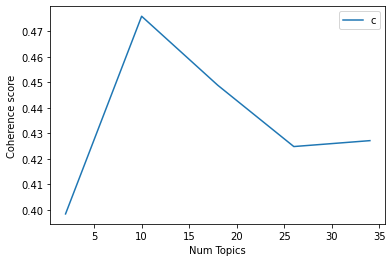

In [39]:
import matplotlib.pyplot as plt

limit=40; start=2; step=8;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [40]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3984
Num Topics = 10  has Coherence Value of 0.4759
Num Topics = 18  has Coherence Value of 0.4489
Num Topics = 26  has Coherence Value of 0.4248
Num Topics = 34  has Coherence Value of 0.4272


In [ ]:
# From this plot can be made conclusion that optimal number of topics is 10

## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling